In [1]:
from copy import copy
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import random
import itertools as iter

In [2]:
def sse(y, yhat):
    return (yhat - y)**2

In [3]:
def mse(y, yhat):
    return np.sum((yhat - y)**2)/len(y)

In [2]:
class LinearReg():
    def __init__(self):
        self.params = None
    def fit(self, Y, X):
        if len(X) != len(Y):
            raise ValueError("X and Y must have the same length.")
        #y = mx + c = Ap, where A = [[x, 1]] and p = [[m], [c]]
        A = np.vstack([X, np.ones(len(X))]).T
        self.m, self.c = np.linalg.lstsq(A, Y, rcond=None)[0]
        #return the model object
        return self
    
    def fit_plane(self, X, Y, Z):
        if len(X) != len(Y) or len(Z) != len(Y):
            raise ValueError("X, Y, Z must have the same length.")
        
        # aX + bY + c = Z 
        # AX = B, where A = [[X, Y, 1]] and X = [[a], [b], [c]] and B = Z
        A = np.vstack([X, Y, np.ones(len(X))]).T #transpose to get column vector
        B = Z.T
        fit = np.linalg.inv(A.T @ A) @ A.T @ B
        self.a = fit[0]
        self.b = fit[1]
        self.c = fit[2]
        return self
    
    def predict(self, X):
        prediction =  X * self.m + self.c
        return prediction
    
    def predict_plane(self, X, Y):
        Z = X * self.a + Y * self.b + self.c
        return Z

    

In [55]:
class RANSAC():
    
    def __init__(self,  model, loss_fun, metric, n = 5, k = 500, t = 0.5, d=10):
        '''This is the constructor for the ransac object.

        Attribute
        ------------
        model: model object implementing fit and predict
        loss: a loss function to assert model fit
        metric: a metric to evaluate model fit (RMSE, MSE)
        n : Minimum number of data points to estimate the parameters
        k : maximum iterations allowed
        t : threshold value to determine if point are fit well.
        d : numbers of close data points required to assert model fit
        '''

        self.default_inlier_prob = 0.8 #use when k is not provided
        self.d = d
        self.model = model
        self.loss_fun = loss_fun
        self.metric = metric
        self.n = n
        self.t = t
        self.k = k
        self.bestFit = None
        self.x_inliers = []
        self.y_inliers = []
        self.z_inliers = []
        self.bestErr = np.inf
    def fit(self, X, Y):
        for i in range(self.k):
            randomIDs = random.sample(range(0, len(X)), self.n) #get n random IDs
            #sampling random points
            maybeInliersX = np.asarray([X[e] for e in (randomIDs)])
            maybeInliersY = np.asarray([Y[e] for e in (randomIDs)])

            #fit model
            maybeModel = self.model.fit(maybeInliersY, maybeInliersX)

            #fit remaining points to model
            yhat = maybeModel.predict(X) 
            loss = self.loss_fun(Y, yhat)

            #get the inliers
            inliersX = np.asarray([X[e] for e in range(len(loss)) if loss[e] < self.t])
            inliersY = np.asarray([Y[e] for e in range(len(loss)) if loss[e] < self.t])

            #check if have sufficient inliers
            if len(inliersX) >= self.d:
                better_model = self.model.fit(inliersY, inliersX)
                yhat_ = better_model.predict(X)
                err = self.metric(Y, yhat_)
                if (err < self.bestErr):
                    self.bestFit = better_model
                    self.bestErr = err
                    self.x_inliers = inliersX #inliers
                    self.y_inliers = inliersY #inliers
        
        #self.bestFit = self.model.fit(self.x_inliers, self.y_inliers) #best error
        if (self.bestFit == None):
            print("No model found")    
        return self

    def fit_3d(self, X, Y, Z):
        combination = []
        for i in range(self.k):
            while True:
                randomIDs = random.sample(range(0, len(X)), self.n) #get n random IDs
                if randomIDs not in combination:
                     combination.append(randomIDs)
                     break
            
            #sampling random points
            maybeInliersX = np.asarray([X[e] for e in (randomIDs)])
            maybeInliersY = np.asarray([Y[e] for e in (randomIDs)])
            maybeInliersZ = np.asarray([Z[e] for e in (randomIDs)])

            #fit model
            maybeModel = self.model.fit_plane(maybeInliersY, maybeInliersX, maybeInliersZ)
            
            #fit remaining points to model
            zhat = maybeModel.predict_plane(X, Y) 
            loss = self.loss_fun(Z, zhat)

            #get the inliers
            inliersX = np.asarray([X[e] for e in range(len(loss)) if loss[e] < self.t])
            inliersY = np.asarray([Y[e] for e in range(len(loss)) if loss[e] < self.t])
            inliersZ = np.asarray([Z[e] for e in range(len(loss)) if loss[e] < self.t])

            #check if have sufficient inlier
            if len(inliersX) >= self.d:
                better_model = self.model.fit_plane(inliersX, inliersY,inliersZ)
                zhat_ = better_model.predict_plane(X, Y)
                err = self.metric(Z, zhat_)
                if (err < self.bestErr):
                    self.bestFit = better_model #best error
                    self.bestErr = err
                    self.x_inliers = inliersX 
                    self.y_inliers = inliersY
                    self.z_inliers = inliersZ 
                
        print("Repeated:", len(combination))    
        return self
    def predict(self, X):
        return self.bestFit.predict(X)

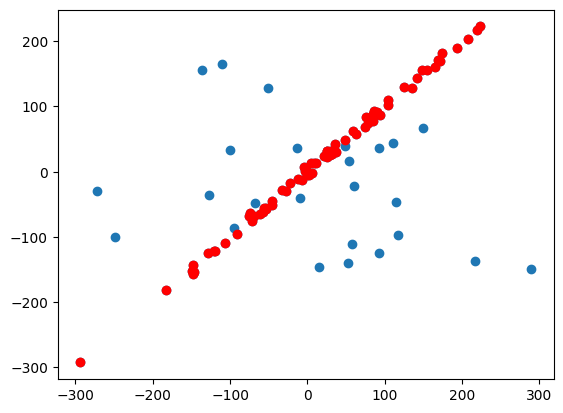

In [4]:
#Dummy data

#define slope and intercept
slope = 1
intercept = 0

num_points = 100

#get the data with the trend
x_ = np.random.normal(0,100,75)
y_ = slope * x_ + intercept
noises = np.random.normal(0, 5, 75)
y_ = y_ + noises
#generate noises
noise_x = np.random.normal(0, 100, 25)
noise_y = np.random.normal(0, 100, 25)
x = np.append(x_, noise_x)
y = np.append(y_, noise_y)
plt.scatter(x, y)
plt.scatter(x_, y_, c='r')
#plt.plot(x, slope* x + intercept, 'r-')

In [49]:
np.random.seed(100)
regressor = RANSAC(model = LinearReg(), 
                   loss_fun = sse, 
                   metric = mse,
                   t = 5,
                   k = 2000,
                    n = 2,
                    d = 30
                    )

In [51]:
regressor = regressor.fit(x,y)

In [52]:
regressor.bestFit.m

0.9699168029203156

In [54]:
regressor.x_inliers.shape

(31,)

In [6]:
lm = LinearReg()
lm.fit(x, y)

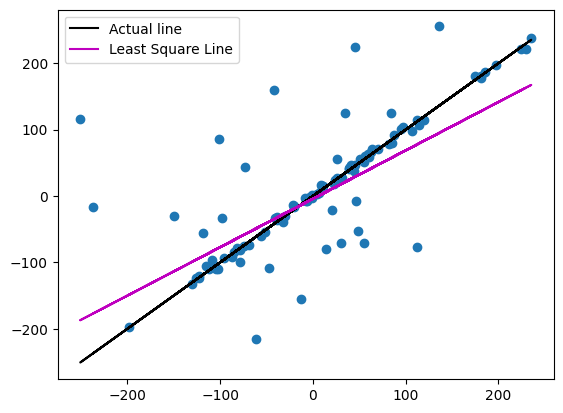

In [7]:
#yval = regressor.bestFit.predict(x)
y_lm = lm.predict(x)
plt.scatter(x, y)
#plt.plot(x, yval, 'r-', label = "RANSAC")
plt.plot(x, slope* x + intercept, 'k-', label = "Actual line")
#plt.plot(regressor.x_inliers, regressor.y_inliers, 'go', label = "inliers")
plt.plot(x, y_lm, 'm-', label = "Least Square Line")
plt.legend()

In [28]:
%matplotlib inline
import matplotlib.pyplot as pltt

In [56]:
np.random.seed(12)
#setting the trend
a = 1
b = 1
c = 0

#inliers
x = np.random.uniform(0, 100, 35)
y = np.random.uniform(0, 100, 35)
noises = np.random.uniform(0, 5, 35)
z = a * x + b * y + c + noises

#outliers
x_noises = np.random.uniform(0,100,25)
y_noises = np.random.uniform(0,100,25)
z_noises = np.random.uniform(0,100,25)

#full dataset
x_ = np.append(x, x_noises)
y_ = np.append(y, y_noises)
z_ = np.append(z, z_noises)

#Least square line
lsq = LinearReg()
lsq.fit_plane(x_, y_, z_)
zhat = lsq.predict_plane(x_, y_)

xx, yy = np.meshgrid(x_, y_)
zz = lsq.a * xx + lsq.b * yy + lsq.c

xxx, yyy, zzz = np.meshgrid(x_, y_, z_)

#real plane
zreal = a*xx + b*yy + c


In [57]:
print(lsq.a, lsq.b, lsq.c)

0.7945013242014088 0.6752639873674072 11.01086769146789


In [58]:
x_

array([15.41628424, 74.00496965, 26.33150152, 53.37393934,  1.45749625,
       91.87470081, 90.07148541,  3.34214276, 95.69493363, 13.72093214,
       28.3828353 , 60.60831844, 94.42251361, 85.27355411,  0.22592335,
       52.12260272, 55.20376333, 48.53774137, 76.81341541, 16.07167531,
       76.45604503,  2.0809798 , 13.52101784, 11.62730174, 30.98975845,
       67.14526452, 47.12297783, 81.6168298 , 28.95867835, 73.31259776,
       70.26223553, 32.75694763, 33.46475291, 97.8058079 , 62.45821117,
        6.98736748, 80.07342342, 91.14340501, 19.4674629 , 21.06076389,
       37.74407824, 40.28472102, 88.51776944, 20.21543434, 41.90148275,
       64.79591733, 51.16429528, 33.38324855, 77.84734339, 13.54351346,
       19.17107723, 40.25891479, 78.68444652, 25.38081939, 10.94854213,
       93.06760144, 12.63872838, 60.50053904, 29.01219366, 62.65293919])

In [59]:
np.random.seed(50)
ransacc = RANSAC(model = LinearReg(), 
                 loss_fun = sse,
                 metric = mse,
                 n = 3,
                 k = 1000,
                 t = 80,
                 d = 15
                )

In [60]:
ransacc.fit_3d(x_, y_, z_)

Repeated: 1000


In [61]:
ransacc.y_inliers

array([40.66403018, 41.92502703, 42.40524466, 22.08525208, 52.32460708,
       41.63696573, 11.36017195, 50.65560757, 46.14402601,  0.80033398,
        1.04384021,  8.46385204, 31.56682369, 24.17802357, 65.93433507])

In [304]:
ransacc.bestErr

1116.4186190331452

In [62]:
print("z = ", ransacc.bestFit.a,"X +", ransacc.bestFit.b,"Y +", ransacc.bestFit.c)

z =  0.9811091246624298 X + 1.0363184135506522 Y + 0.9294474652873252


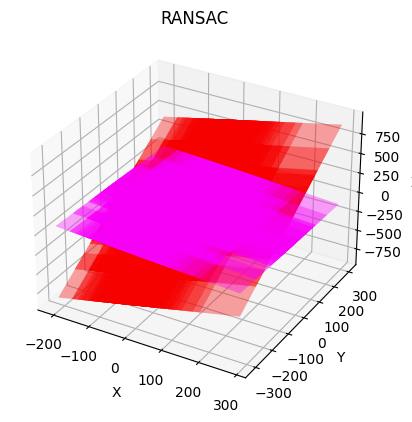

In [164]:
#Begin plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

inliersX = ransacc.x_inliers
inliersY = ransacc.y_inliers
inliersZ = ransacc.z_inliers

xi, yi, zi = np.meshgrid(inliersX, inliersY, inliersX)
ax.scatter3D(xi,yi,zi, marker = 'x', c='k', alpha = 1, zorder = 1)

#Plot the scatter points with depth sorting enabled
#ax.scatter3D(xxx, yyy, zzz, marker='o', c='g', zorder=3, alpha = 0.05)

# Plot the surface with depth sorting enabled
surf_zhat = ax.plot_surface(xx, yy, ransacc.bestFit.a * xx + ransacc.bestFit.b * yy + ransacc.bestFit.c, alpha=0.1, zorder=2, facecolor = 'magenta')




# x = [0, 0, 200, 200, 0]
# y = [0, 200, 200, 0, 0]
# z = [6, 406, 606, 206, 6]

# ax.plot(x[:2], y[:2], z[:2], 'k--', zorder = 1)
# ax.plot(x[1:3], y[1:3], z[1:3], 'k--', zorder = 1)
# ax.plot(x[2:4], y[2:4], z[2:4], 'k--', zorder = 1)
# ax.plot([x[0], x[3]], [y[0], y[3]], [z[0], z[3]], 'k--', zorder = 1)

surf_zreal = ax.plot_surface(xx, yy, zreal, alpha=0.1, zorder=2, facecolor = 'red')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('RANSAC')

# Display the plot
plt.show()